In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [ ]:
import plotly.offline as pyoff
import plotly.graph_objs as go

Lifetime Value (LTV) prediction:
- define time frame
- identify features: RFM scores
- calculate LTV for training
- build ML model


# Data

In [ ]:
# retail_df
retail_df = pd.read_csv('data/OnlineRetail.csv', encoding='unicode_escape')
## 'InvoiceDate': convert to datetime
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'])
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
# retail_UK_df
retail_UK_df = retail_df.query('Country == "United Kingdom"')
# retail_UK_df = retail_df.loc[retail_df['Country'] == 'United Kingdom']
retail_UK_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
print('retail_UK_df has {} rows and {} columns'.format(retail_UK_df.shape[0], retail_UK_df.shape[1]))

retail_UK_df has 495478 rows and 8 columns


# Time frame
- features: 3 months
- LTV caluculation: next 6 months

In [ ]:
retail_UK_df['InvoiceDate'].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                  495478
unique                  21220
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:49:00
Name: InvoiceDate, dtype: object

In [ ]:
# create 3m dataframe: (2011, 3, 1) to (2011, 5, 31)
from datetime import datetime, timedelta, date

retail_UK3m_df = retail_UK_df.loc[(retail_UK_df['InvoiceDate'].dt.date >= date(2011, 3, 1)) & (retail_UK_df['InvoiceDate'].dt.date < date(2011, 6, 1))]
retail_UK3m_df = retail_UK3m_df.reset_index(drop=True)
retail_UK3m_df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
95188,555150,22895,SET OF 2 TEA TOWELS APPLE AND PEARS,3,2011-05-31 15:53:00,3.25,NaN,United Kingdom
95189,555150,22983,CARD BILLBOARD FONT,3,2011-05-31 15:53:00,0.42,NaN,United Kingdom
95190,555150,23169,CLASSIC GLASS COOKIE JAR,3,2011-05-31 15:53:00,4.15,NaN,United Kingdom
95191,555150,23298,SPOTTY BUNTING,5,2011-05-31 15:53:00,4.95,NaN,United Kingdom
95192,555150,23118,PARISIENNE JEWELLERY DRAWER,2,2011-05-31 15:53:00,7.50,NaN,United Kingdom


In [ ]:
retail_UK3m_df['InvoiceDate'].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                   95193
unique                   4852
top       2011-04-18 13:13:00
freq                      333
first     2011-03-01 08:30:00
last      2011-05-31 15:53:00
Name: InvoiceDate, dtype: object

In [ ]:
# create next 6m dataframe: (2011, 6, 1) to (2011, 11, 31)
retail_UK6m_df = retail_UK_df.loc[(retail_UK_df['InvoiceDate'].dt.date >= date(2011, 6, 1)) & (retail_UK_df['InvoiceDate'].dt.date < date(2011, 12, 1))]
retail_UK6m_df = retail_UK6m_df.reset_index(drop=True)
retail_UK6m_df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
278961,C579886,22197,POPCORN HOLDER,-1,2011-11-30 17:39:00,0.85,15676.0,United Kingdom
278962,C579886,23146,TRIPLE HOOK ANTIQUE IVORY ROSE,-1,2011-11-30 17:39:00,3.29,15676.0,United Kingdom
278963,C579887,84946,ANTIQUE SILVER T-LIGHT GLASS,-1,2011-11-30 17:42:00,1.25,16717.0,United Kingdom
278964,C579887,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2011-11-30 17:42:00,7.95,16717.0,United Kingdom
278965,C579887,23490,T-LIGHT HOLDER HANGING LOVE BIRD,-3,2011-11-30 17:42:00,3.75,16717.0,United Kingdom


In [ ]:
retail_UK6m_df['InvoiceDate'].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                  278966
unique                  11477
top       2011-10-31 14:41:00
freq                     1114
first     2011-06-01 07:37:00
last      2011-11-30 17:42:00
Name: InvoiceDate, dtype: object

# Features
- calculate RFM scores in 3 months

In [ ]:
# create user_UK3m_df
user_UK3m_df = pd.DataFrame(retail_UK3m_df['CustomerID'].unique())
user_UK3m_df.columns = ['CustomerID']
user_UK3m_df.head()

,CustomerID
0,14620.0
1,14740.0
2,13880.0
3,16462.0
4,17068.0


In [ ]:
print('user_UK3m_df has {} rows and {} columns'.format(user_UK3m_df.shape[0], user_UK3m_df.shape[1]))

user_UK3m_df has 1841 rows and 1 columns


## Recency

In [ ]:
# create last_purchase_date
last_purchase_date = retail_UK3m_df.groupby('CustomerID')['InvoiceDate'].max()
last_purchase_date = last_purchase_date.reset_index()
last_purchase_date.head()

,CustomerID,InvoiceDate
0,12747.0,2011-05-25 09:57:00
1,12748.0,2011-05-31 12:50:00
2,12749.0,2011-05-23 17:08:00
3,12821.0,2011-05-09 15:51:00
4,12823.0,2011-03-30 10:36:00


In [ ]:
# calculate recency
## recency: number of inactive days
last_purchase_date['Recency'] = last_purchase_date['InvoiceDate'].max() - last_purchase_date['InvoiceDate']
last_purchase_date['Recency'] = last_purchase_date['Recency'].dt.days
last_purchase_date.head()

,CustomerID,InvoiceDate,Recency
0,12747.0,2011-05-25 09:57:00,6
1,12748.0,2011-05-31 12:50:00,0
2,12749.0,2011-05-23 17:08:00,7
3,12821.0,2011-05-09 15:51:00,21
4,12823.0,2011-03-30 10:36:00,62


In [ ]:
# merge with user_UK3m_df
user_UK3m_df = pd.merge(user_UK3m_df, last_purchase_date[['CustomerID', 'Recency']], on='CustomerID')
user_UK3m_df.head()

,CustomerID,Recency
0,14620.0,12
1,14740.0,4
2,13880.0,25
3,16462.0,91
4,17068.0,11


In [ ]:
# describe 'Recency'
user_UK3m_df['Recency'].describe()

count    1840.000000
mean       35.145652
std        26.231112
min         0.000000
25%        12.000000
50%        26.000000
75%        56.000000
max        91.000000
Name: Recency, dtype: float64

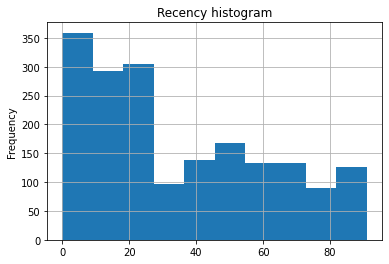

In [ ]:
# plot 'Recency' histogram
user_UK3m_df['Recency'].plot(kind='hist', grid=True, title='Recency histogram')
plt.show()

### - Kmeans clustering

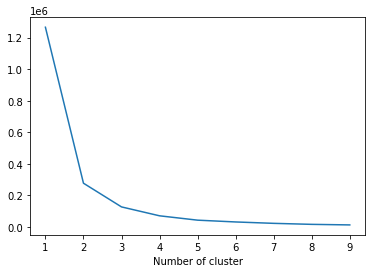

In [ ]:
# indentify number of clusters
## Elbow method
from sklearn.cluster import KMeans

cluster = user_UK3m_df[['Recency']]
sse = {}

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(cluster)
    sse[i] = kmeans.inertia_ # sum of squared distances of samples to closest cluster center

## plot: n_clusters=4
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of cluster')
plt.show()

In [ ]:
# apply Kmeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(user_UK3m_df[['Recency']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
# create 'RecencyCluster' as recency score
user_UK3m_df['RecencyCluster'] = kmeans.predict(user_UK3m_df[['Recency']])
user_UK3m_df.head()

,CustomerID,Recency,RecencyCluster
0,14620.0,12,0
1,14740.0,4,0
2,13880.0,25,3
3,16462.0,91,1
4,17068.0,11,0


In [ ]:
## clusters not in order
user_UK3m_df.groupby(['RecencyCluster'])['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,608.0,8.312500,4.404323,0.0,5.0,8.0,12.0,16.0
1,349.0,76.885387,8.373023,64.0,70.0,76.0,84.0,91.0
2,439.0,50.020501,7.377743,39.0,43.0,49.0,56.0,63.0
3,444.0,24.373874,4.959870,17.0,20.0,23.0,27.0,35.0


In [ ]:
# function for ordering cluster numbers
## ascending: True in case the higher target value, the higher score
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={'index': cluster_field_name})

    return df_final

In [ ]:
# get clusters ordered
user_UK3m_df = order_cluster('RecencyCluster', 'Recency', user_UK3m_df, ascending=False)
user_UK3m_df.head()

,CustomerID,Recency,RecencyCluster
0,14620.0,12,3
1,14740.0,4,3
2,17068.0,11,3
3,12971.0,4,3
4,15194.0,6,3


In [ ]:
# cluster profile
user_UK3m_df.groupby(['RecencyCluster'])['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,349.0,76.885387,8.373023,64.0,70.0,76.0,84.0,91.0
1,439.0,50.020501,7.377743,39.0,43.0,49.0,56.0,63.0
2,444.0,24.373874,4.959870,17.0,20.0,23.0,27.0,35.0
3,608.0,8.312500,4.404323,0.0,5.0,8.0,12.0,16.0


## Frequency

In [ ]:
# calculate frequency
## frequency: total number of orders
frequency = retail_UK3m_df.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index() # create dataframe
frequency.columns = ['CustomerID', 'Frequency'] # rename columns
frequency.head()

,CustomerID,Frequency
0,12747.0,35
1,12748.0,582
2,12749.0,54
3,12821.0,6
4,12823.0,1


In [ ]:
# merge with user_UK3m_df
user_UK3m_df = pd.merge(user_UK3m_df, frequency, on='CustomerID')
user_UK3m_df.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,14620.0,12,3,30
1,14740.0,4,3,89
2,17068.0,11,3,76
3,12971.0,4,3,73
4,15194.0,6,3,64


In [ ]:
# describe 'Frequency'
user_UK3m_df['Frequency'].describe()

count    1840.000000
mean       38.958152
std        60.968929
min         1.000000
25%        12.000000
50%        23.000000
75%        47.000000
max      1364.000000
Name: Frequency, dtype: float64

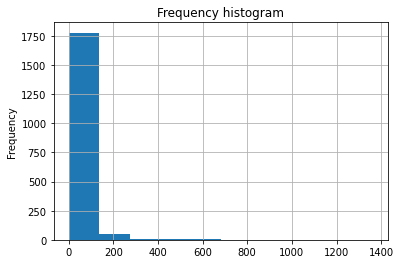

In [ ]:
# plot 'Frequency' histogram
user_UK3m_df['Frequency'].plot(kind='hist', grid=True, title='Frequency histogram')
plt.show()

### - Kmeans clustering

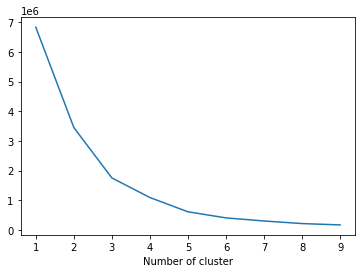

In [ ]:
# indentify number of clusters
## Elbow method
from sklearn.cluster import KMeans

cluster = user_UK3m_df[['Frequency']]
sse = {}

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(cluster)
    sse[i] = kmeans.inertia_ # sum of squared distances of samples to closest cluster center

## plot: n_clusters=4
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of cluster')
plt.show()

In [ ]:
# apply Kmeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(user_UK3m_df[['Frequency']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
# create 'FrequencyCluster' as frequency score
user_UK3m_df['FrequencyCluster'] = kmeans.predict(user_UK3m_df[['Frequency']])
user_UK3m_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,14620.0,12,3,30,0
1,14740.0,4,3,89,2
2,17068.0,11,3,76,2
3,12971.0,4,3,73,2
4,15194.0,6,3,64,0


In [ ]:
# clusters not in order
user_UK3m_df.groupby(['FrequencyCluster'])['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1605.0,24.218069,17.761893,1.0,10.0,20.0,36.0,70.0
1,11.0,496.000000,125.912668,331.0,422.5,452.0,570.0,730.0
2,223.0,116.560538,43.816927,71.0,83.5,104.0,131.5,285.0
3,1.0,1364.000000,NaN,1364.0,1364.0,1364.0,1364.0,1364.0


In [ ]:
# get clusters ordered
user_UK3m_df = order_cluster('FrequencyCluster', 'Frequency', user_UK3m_df, ascending=True)
user_UK3m_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,14620.0,12,3,30,0
1,15194.0,6,3,64,0
2,18044.0,5,3,57,0
3,18075.0,12,3,35,0
4,15241.0,0,3,64,0


In [ ]:
# cluster profile
user_UK3m_df.groupby(['FrequencyCluster'])['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1605.0,24.218069,17.761893,1.0,10.0,20.0,36.0,70.0
1,223.0,116.560538,43.816927,71.0,83.5,104.0,131.5,285.0
2,11.0,496.000000,125.912668,331.0,422.5,452.0,570.0,730.0
3,1.0,1364.000000,NaN,1364.0,1364.0,1364.0,1364.0,1364.0


## Monetary value (revenue)

In [ ]:
# create 'Revenue' for retail_UK3m_df
retail_UK3m_df['Revenue'] = retail_UK3m_df['UnitPrice'] * retail_UK3m_df['Quantity']
retail_UK3m_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,545220,21955,DOORMAT UNION JACK GUNS AND ROSES,2,2011-03-01 08:30:00,7.95,14620.0,United Kingdom,15.90
1,545220,48194,DOORMAT HEARTS,2,2011-03-01 08:30:00,7.95,14620.0,United Kingdom,15.90
2,545220,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-03-01 08:30:00,1.65,14620.0,United Kingdom,19.80
3,545220,22139,RETROSPOT TEA SET CERAMIC 11 PC,3,2011-03-01 08:30:00,4.95,14620.0,United Kingdom,14.85
4,545220,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,2011-03-01 08:30:00,3.75,14620.0,United Kingdom,15.00


In [ ]:
# calculate 3m revenue
## revenue: total revenue
revenue = retail_UK3m_df.groupby('CustomerID')['Revenue'].sum()
revenue = revenue.reset_index()
revenue.head()

,CustomerID,Revenue
0,12747.0,1082.09
1,12748.0,4336.73
2,12749.0,782.10
3,12821.0,92.72
4,12823.0,459.00


In [ ]:
# merge with user_UK3m_df
user_UK3m_df = pd.merge(user_UK3m_df, revenue, on='CustomerID')
user_UK3m_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,14620.0,12,3,30,0,393.28
1,15194.0,6,3,64,0,1439.02
2,18044.0,5,3,57,0,808.96
3,18075.0,12,3,35,0,638.12
4,15241.0,0,3,64,0,947.55


In [ ]:
# describe 'Revenue'
user_UK3m_df['Revenue'].describe()

count     1840.000000
mean       738.715017
std       1640.430156
min      -1462.500000
25%        210.237500
50%        369.825000
75%        749.490000
max      35085.480000
Name: Revenue, dtype: float64

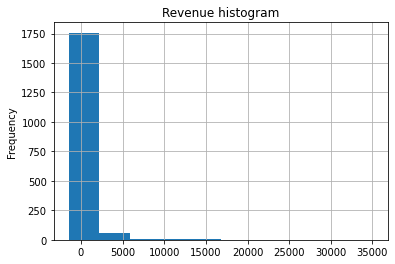

In [ ]:
# plot 'Revenue' histogram
user_UK3m_df['Revenue'].plot(kind='hist', grid=True, title='Revenue histogram')
plt.show()

### - Kmeans clustering

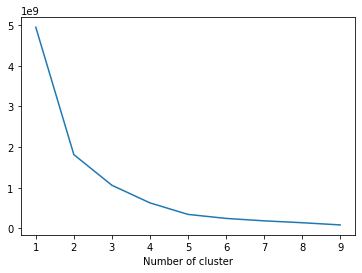

In [ ]:
# indentify number of clusters
## Elbow method
from sklearn.cluster import KMeans

cluster = user_UK3m_df[['Revenue']]
sse = {}

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(cluster)
    sse[i] = kmeans.inertia_ # sum of squared distances of samples to closest cluster center

## plot: n_clusters=4
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of cluster')
plt.show()

In [ ]:
# apply Kmeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(user_UK3m_df[['Revenue']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
# create 'RevenueCluster' as revenue score
user_UK3m_df['RevenueCluster'] = kmeans.predict(user_UK3m_df[['Revenue']])
user_UK3m_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,14620.0,12,3,30,0,393.28,0
1,15194.0,6,3,64,0,1439.02,0
2,18044.0,5,3,57,0,808.96,0
3,18075.0,12,3,35,0,638.12,0
4,15241.0,0,3,64,0,947.55,0


In [ ]:
# clusters not in order
user_UK3m_df.groupby(['RevenueCluster'])['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,1756.0,504.760245,444.567580,-1462.50,204.3075,349.590,666.8325,2131.72
1,10.0,14092.686000,2855.109881,10348.13,11268.3675,15124.345,16124.8250,17700.64
2,72.0,3760.423486,1538.877714,2159.16,2685.1875,3141.610,4222.5050,7969.99
3,2.0,30599.645000,6343.928696,26113.81,28356.7275,30599.645,32842.5625,35085.48


In [ ]:
# get clusters ordered
user_UK3m_df = order_cluster('RevenueCluster', 'Revenue', user_UK3m_df, ascending=True)
user_UK3m_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,14620.0,12,3,30,0,393.28,0
1,15194.0,6,3,64,0,1439.02,0
2,18044.0,5,3,57,0,808.96,0
3,18075.0,12,3,35,0,638.12,0
4,15241.0,0,3,64,0,947.55,0


In [ ]:
# cluster profile
user_UK3m_df.groupby(['RevenueCluster'])['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,1756.0,504.760245,444.567580,-1462.50,204.3075,349.590,666.8325,2131.72
1,72.0,3760.423486,1538.877714,2159.16,2685.1875,3141.610,4222.5050,7969.99
2,10.0,14092.686000,2855.109881,10348.13,11268.3675,15124.345,16124.8250,17700.64
3,2.0,30599.645000,6343.928696,26113.81,28356.7275,30599.645,32842.5625,35085.48


## Overall score

In [ ]:
# calculate overall score
user_UK3m_df['OverallScore'] = user_UK3m_df['RecencyCluster'] + user_UK3m_df['FrequencyCluster'] + user_UK3m_df['RevenueCluster']
user_UK3m_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore
0,14620.0,12,3,30,0,393.28,0,3
1,15194.0,6,3,64,0,1439.02,0,3
2,18044.0,5,3,57,0,808.96,0,3
3,18075.0,12,3,35,0,638.12,0,3
4,15241.0,0,3,64,0,947.55,0,3


In [ ]:
# user profile
user_UK3m_df.groupby('OverallScore')[['Recency', 'Frequency', 'Revenue']].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,77.014925,18.432836,295.824239
1,50.887828,24.522673,367.334177
2,26.590476,31.028571,500.973095
3,10.243902,36.652439,633.871402
4,8.109375,103.835938,1983.985086
5,6.482759,138.965517,4326.155172
6,7.357143,322.071429,12177.627143
7,3.000000,779.333333,11350.896667


### - Segmentation based on overall score
- 0-2: low value
- 3-4: mid value
- 5+: high value

In [ ]:
# segmentation
user_UK3m_df['Segment'] = 'Low-Value'
user_UK3m_df.loc[user_UK3m_df['OverallScore'] >= 3, 'Segment'] = 'Mid-Value'
user_UK3m_df.loc[user_UK3m_df['OverallScore'] >= 5, 'Segment'] = 'High-Value'
user_UK3m_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value


In [ ]:
user_UK3m_df['Segment'].value_counts()

Low-Value     1174
Mid-Value      620
High-Value      46
Name: Segment, dtype: int64

There are 46 high-value customers identified in 3 months (March-May)

In [ ]:
# user profile
user_UK3m_df.groupby('Segment')[['Recency', 'Frequency', 'Revenue']].mean()

,Recency,Frequency,Revenue
Segment,,,
High-Value,6.521739,236.456522,7173.868913
Low-Value,49.650767,25.112436,394.738365
Mid-Value,9.803226,50.522581,912.604550


# Customer lifetime value
- calculate customer LTV in next 6 months

In [ ]:
# calculate 'Revenue' for retail_UK6m_df
retail_UK6m_df['Revenue'] = retail_UK6m_df['UnitPrice'] * retail_UK6m_df['Quantity']
retail_UK6m_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,555156,23299,FOOD COVER WITH BEADS SET 2,6,2011-06-01 07:37:00,3.75,15643.0,United Kingdom,22.50
1,555156,22847,BREAD BIN DINER STYLE IVORY,1,2011-06-01 07:37:00,16.95,15643.0,United Kingdom,16.95
2,555157,23075,PARLOUR CERAMIC WALL HOOK,16,2011-06-01 07:38:00,4.15,15643.0,United Kingdom,66.40
3,555157,47590B,PINK HAPPY BIRTHDAY BUNTING,6,2011-06-01 07:38:00,5.45,15643.0,United Kingdom,32.70
4,555157,22423,REGENCY CAKESTAND 3 TIER,4,2011-06-01 07:38:00,12.75,15643.0,United Kingdom,51.00


In [ ]:
# calculate 6m revenue
revenue_6m = retail_UK6m_df.groupby('CustomerID')['Revenue'].sum()
revenue_6m = revenue_6m.reset_index()
revenue_6m.columns = ['CustomerID', 'Revenue_6m']
revenue_6m.head()

,CustomerID,Revenue_6m
0,12747.0,1666.11
1,12748.0,18679.01
2,12749.0,2323.04
3,12820.0,561.53
4,12822.0,918.98


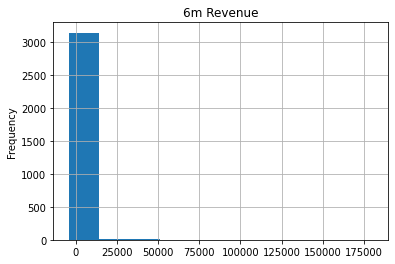

In [ ]:
# plot 'Revenue_6m' histogram
revenue_6m['Revenue_6m'].plot(kind='hist', grid=True, title='6m Revenue')
plt.show()

In [ ]:
# plot 'Revenue_6m' histogram
plot_data = [
    go.Histogram(
        x=revenue_6m.query('Revenue_6m < 10000')['Revenue_6m']
    )
]

plot_layout = go.Layout(
    title='6m Revenue'
)

fig=go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# Data preprocessing
- merge 3m and 6m dfs
- check corellation between LTV and RFM scores
- remove outliers: by quantile(0.99) of revenue
- segment LTV using Kmeans => classification model
- features engineering: encoding categorical cols
- split training and test datasets


In [ ]:
# merge user_UK3m_df and revenue_6m
user_UK_df = pd.merge(user_UK3m_df, revenue_6m, how='left', on='CustomerID')
user_UK_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Revenue_6m
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,NaN
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value,3232.20
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value,991.54
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value,1322.75
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value,791.04


In [ ]:
# missing values check
user_UK_df.isna().sum()

CustomerID            0
Recency               0
RecencyCluster        0
Frequency             0
FrequencyCluster      0
Revenue               0
RevenueCluster        0
OverallScore          0
Segment               0
Revenue_6m          449
dtype: int64

In [ ]:
# fill missing values
user_UK_df = user_UK_df.fillna(value=0)

In [ ]:
# describe 'Revenue_6m'
user_UK_df['Revenue_6m'].describe()

count      1840.000000
mean       1477.073865
std        6039.528767
min        -609.400000
25%           0.000000
50%         515.085000
75%        1375.695000
max      180469.050000
Name: Revenue_6m, dtype: float64

In [ ]:
# plot scatter: RFM score and LTV (6m revenue) to see the correlation
# plot_df = user_UK_df.query('Revenue_6m < 30000')
plot_df = user_UK_df.loc[user_UK_df['Revenue_6m'] < 30000]

plot_data = [
    go.Scatter(
        x=plot_df.query('Segment == "Low-Value"')['OverallScore'],
        y=plot_df.query('Segment == "Low-Value"')['Revenue_6m'],
        mode='markers',
        name='Low',
        marker=dict(
            size=7,
            line=dict(width=1),
            color='blue',
            opacity=0.8
        )
    ),
    go.Scatter(
        x=plot_df.query('Segment == "Mid-Value"')['OverallScore'],
        y=plot_df.query('Segment == "Mid-Value"')['Revenue_6m'],
        mode='markers',
        name='Mid',
        marker=dict(
            size=9,
            line=dict(width=1),
            color='green',
            opacity=0.5
        )
    ),
    go.Scatter(
        x=plot_df.query('Segment == "High-Value"')['OverallScore'],
        y=plot_df.query('Segment == "High-Value"')['Revenue_6m'],
        mode='markers',
        name='High',
        marker=dict(
            size=11,
            line=dict(width=1),
            color='red',
            opacity=0.9
        )
    ),
]

plot_layout = go.Layout(
    yaxis={'title': '6m LTV'},
    xaxis={'title': 'RFM score'},
    title='RFM score vs 6m LTV'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Positive correlation is quite visible: higher RFM score means higher LTV

## Remove outliers

In [ ]:
# remove outliers: quantile(0.99)
cut = user_UK_df['Revenue_6m'].quantile(0.99)
user_UK_df = user_UK_df.loc[user_UK_df['Revenue_6m'] < cut]
user_UK_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Revenue_6m
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,0.00
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value,3232.20
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value,991.54
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value,1322.75
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value,791.04


## Segmentation based on LTV
- Kmeans clustering
- 3 segments: Low LTV, Mid LTV and High LTV

In [ ]:
# apply Kmeans: create 'LTVCLuster'
kmeans = KMeans(n_clusters=3)
kmeans.fit(user_UK_df[['Revenue_6m']])

user_UK_df['LTVCluster'] = kmeans.predict(user_UK_df[['Revenue_6m']])
user_UK_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Revenue_6m,LTVCluster
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,0.00,0
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value,3232.20,2
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value,991.54,0
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value,1322.75,0
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value,791.04,0


In [ ]:
# get LTV clusters ordered
user_UK_df = order_cluster('LTVCluster', 'Revenue_6m', user_UK_df, ascending=True)
user_UK_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Revenue_6m,LTVCluster
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,0.00,0
1,18044.0,5,3,57,0,808.96,0,3,Mid-Value,991.54,0
2,18075.0,12,3,35,0,638.12,0,3,Mid-Value,1322.75,0
3,15241.0,0,3,64,0,947.55,0,3,Mid-Value,791.04,0
4,15660.0,4,3,34,0,484.62,0,3,Mid-Value,858.09,0


In [ ]:
# user profile
user_UK_df.groupby('LTVCluster')['Revenue_6m'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1394.0,396.137189,419.891843,-609.40,0.000,294.220,682.4300,1429.87
1,371.0,2492.794933,937.341566,1445.31,1731.980,2162.930,3041.9550,5287.39
2,56.0,8222.565893,2983.572030,5396.44,6151.435,6986.545,9607.3225,16756.31


## Feature engineering

In [ ]:
# create data_df
data_df = user_UK_df.copy()
data_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,Revenue_6m,LTVCluster
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,0.00,0
1,18044.0,5,3,57,0,808.96,0,3,Mid-Value,991.54,0
2,18075.0,12,3,35,0,638.12,0,3,Mid-Value,1322.75,0
3,15241.0,0,3,64,0,947.55,0,3,Mid-Value,791.04,0
4,15660.0,4,3,34,0,484.62,0,3,Mid-Value,858.09,0


In [ ]:
# categorical features: onehot encoding
data_df = pd.get_dummies(data=data_df) # columns='Segment'
data_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Revenue_6m,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,14620.0,12,3,30,0,393.28,0,3,0.00,0,0,0,1
1,18044.0,5,3,57,0,808.96,0,3,991.54,0,0,0,1
2,18075.0,12,3,35,0,638.12,0,3,1322.75,0,0,0,1
3,15241.0,0,3,64,0,947.55,0,3,791.04,0,0,0,1
4,15660.0,4,3,34,0,484.62,0,3,858.09,0,0,0,1


In [ ]:
# calculate correlation
corr = data_df.corr()
corr['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
Revenue_6m            0.845933
Revenue               0.600491
RevenueCluster        0.467191
OverallScore          0.373114
FrequencyCluster      0.366366
Frequency             0.359601
Segment_High-Value    0.352387
RecencyCluster        0.236899
Segment_Mid-Value     0.168473
CustomerID           -0.028401
Recency              -0.237249
Segment_Low-Value    -0.266008
Name: LTVCluster, dtype: float64

In [ ]:
# create feature set and label
X = data_df.drop(['CustomerID', 'Revenue_6m', 'LTVCluster'], axis=1)
y = data_df['LTVCluster']

In [ ]:
# train and test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [ ]:
X_train.shape

(1729, 10)

In [ ]:
X_test.shape

(92, 10)

# Multiclassification model: XGBoost
- build model
- evaluation: accuracy, classification_report

In [ ]:
# build xgb_model
## multiclassification => objective='multi:softprob'
import xgboost as xgb

xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', n_jobs=-1)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# accuracy
# from sklearn.metrics import accuracy_score

print('accuracy of XGBClassifier on training set: {}'.format(xgb_model.score(X_train, y_train)))
print('accuracy of XGBClassifier on test set: {}'.format(xgb_model.score(X_test, y_test)))

accuracy of XGBClassifier on training set: 0.8935801041064199
accuracy of XGBClassifier on test set: 0.75


In [ ]:
# y_pred
y_pred = xgb_model.predict(X_test)

In [ ]:
# classification_report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85        69
           1       0.44      0.38      0.41        21
           2       0.50      0.50      0.50         2

    accuracy                           0.75        92
   macro avg       0.59      0.58      0.59        92
weighted avg       0.74      0.75      0.74        92



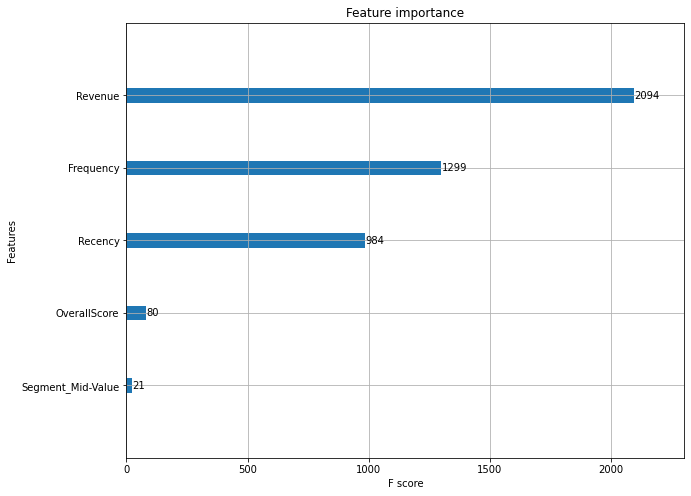

In [ ]:
# plot_importance
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(xgb_model, ax=ax)
plt.show()